
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)



## 7: Studying trends over time in Political Manifestos (1964-2020)


## Text Mining for Historians (with Python)
## A Gentle Introduction to Working with Textual Data in Python

### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">






This notebook combines the insights and techniques from previous sessions and explores a more realistic research example that focuses on studying trends over time in the UK Political Manifestos between 1964 and 2020. By creatively putting the stuff together you've seen so far, you can start to interrogate these corpora from a longitudinal perspective.

This notebook will focus on plotting timelines showing (relative) frequencies for selected (or target) tokens.

**[Important]** Please run the following cells, which download and extract the data needed in the remainder of the Notebook. If you are using Colab and you need to restart the Kernel/Runtime (or it restarted by itself), please run these cells again.

In [1]:
!mkdir working_data
!mkdir working_data/manifestos

In [2]:
!wget -O working_data/manifestos.zip https://github.com/kasparvonbeelen/ghi_python/blob/main/data/manifestos/python.zip?raw=true
!unzip -o working_data/manifestos.zip -d working_data/manifestos

--2021-06-17 13:40:43--  https://github.com/kasparvonbeelen/ghi_python/blob/main/data/manifestos/python.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kasparvonbeelen/ghi_python/raw/main/data/manifestos/python.zip [following]
--2021-06-17 13:40:43--  https://github.com/kasparvonbeelen/ghi_python/raw/main/data/manifestos/python.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kasparvonbeelen/ghi_python/main/data/manifestos/python.zip [following]
--2021-06-17 13:40:44--  https://raw.githubusercontent.com/kasparvonbeelen/ghi_python/main/data/manifestos/python.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githu

First, we start with collecting paths to our manifesto files. These are stored as separate `.txt` files one for each manifesto. As seen previously, we rely on an external library that we need to import first.

We first define where our data is stored and create a `Path()` object to which we apply `Path.glob()`, with `"*.txt"` as the argument. The asterisk `*` serves as a wild card. Basically what are saying here is: in the folder `'working_data/Manifestos/Processed/'` return as files ending with `.txt` (we don't care what precedes the `.txt` extension).

There is one last technicality we can ignore for now: we convert the result of `.glob()` to a `list`. 

In [3]:
from pathlib import Path
folder = Path('working_data/manifestos/Processed/')
files = folder.glob('*.txt')
file_paths = list(files)

Now we can count the number of documents in our corpus by applying the `len()` function to the variable `file_paths`

In [4]:
len(file_paths)

68

And, using index notation, we print the path to the first file in our corpus (not the content itself, this is for later!)

In [6]:
file_paths[0]

PosixPath('working_data/Manifestos/Processed/51421_201912.txt')

So far we've used several tools such as `word_tokenize()` and `Counter()` to count tokens. In this Notebook, we want to repeat this procedure for all documents in our collection. We can write a **function** that takes a path as an argument and returns a mapping between word types and their frequencies. 

The code cell below takes care of this we first import the tools we need and create a function to open a document and compute word frequencies. To create this function, we use the `def` keyword followed by a name, parentheses and a colon. The word between the parenthesis defines the arguments this function accepts.

All the code inside this function should look familiar. For each given path, the function executes the sequence of statements (note the indentation) and returns the variable `word_counts`.

It is important to run the cell below (but only once). Python will then store the function `count_words` into memory so you can reuse it later.

In [7]:
from collections import Counter # import Counter for computing word frequencies
import nltk # import nltk
nltk.download('punkt') # we need this download to use the tokenizer
from nltk.tokenize import word_tokenize # impor the tool for tokenizing strings

def count_words(path): # define the function and the arguments it accepts
    text = open(path,'r').read() # open the document
    text_lowercase = text.lower() # lowercase the text and store in text_lowercase
    tokens = word_tokenize(text_lowercase) # get the tokens as a list
    word_counts = Counter(tokens) # compute word frequencies with Counter()
    return word_counts # return the word frequencies


To check if the function we created is ready, print`count_words`. You'll see that it is now stored as a `function` object.

In [9]:
print(count_words)

<function count_words at 0x120e6cb90>


We can apply this function to the first document by passing `file_paths[0]` as an argument. The second line prints the ten most frequent words.

In [10]:
word_counts = count_words(file_paths[0])
word_counts.most_common(10)

[('the', 1433),
 ('and', 1324),
 ('to', 1127),
 ('.', 1035),
 (',', 1028),
 ('of', 713),
 ('a', 551),
 ('in', 497),
 ('for', 427),
 ('that', 320)]

We know how to count words, but the goal is to plot word counts over time. When you look more closely at the path and file name (i.e. the part after the last `/` you'll notice that it encodes a time-stamp.

The filenames are structured as follows `{party identifier}_{year}{month}.{extension}`. Such a setup—where the filename encodes metadata is rather common when working with heritage collections. We can now start writing a function that extracts the time-stamp from the filename.

First, we print get the file name from the full path (we use the `.stem` attribute here).

In [13]:
first_file = file_paths[0]
print(first_file)
file_name = first_file.stem
print(file_name)

working_data/Manifestos/Processed/51421_201912.txt
51421_201912


Now, we only need to extract the date information from the file name. We slice the first four characters from the string and convert it to an integer. 

In [14]:
file_name[-6:-2]

'2019'

In [15]:
int(file_name[-6:-2])

2019

Slightly changing the indices we can capture both year and month.

In [17]:
year = int(file_name[-6:-2])
month = int(file_name[-2:])
print(year, month)

2019 12


In the very last step, we use a library `datetime` to convert these numbers (year and month are just integer values) to a proper timestamp. Since we don't have access to the exact day we just use the first day of the month.

In [18]:
import datetime
time_stamp = datetime.datetime(year,month,1)
time_stamp

datetime.datetime(2019, 12, 1, 0, 0)

That were many steps! Since we like to repear it for each file, it is again useful to package them in one function.

In [19]:
def path2timestamp(path):
    file_name = path.stem
    year = int(file_name[-6:-2])
    month = int(file_name[-2:])
    time_stamp = datetime.datetime(year,month,1)
    return time_stamp

We are almost ready to explore our corpus! We iterate over our corpus with a `for` and apply both our functions to each document. To keep track of our yearly counts we store the results in a dictionary to map time-stamps to word counts.

The code below reminds you how iteration works. We loop over each element in `file_paths`, and `p` (the loop variable) takes each value (path) in turn. 

In [21]:
for p in file_paths[:10]:
    print(p.name)

51421_201912.txt
51340_201505.txt
51902_200106.txt
51620_197410.txt
51621_201505.txt
51903_201706.txt
51420_198706.txt
51210_201706.txt
51320_198706.txt
51210_201505.txt


You are free to choose any name for `p` as long as you use it consistently!

In [90]:
for fp in file_paths[:10]:
    print(fp.name)

51421_201912.txt
51340_201505.txt
51902_200106.txt
51620_197410.txt
51621_201505.txt
51903_201706.txt
51420_198706.txt
51210_201706.txt
51320_198706.txt
51210_201505.txt


The `for` loop below raises a `NameError` as we did not define `pp`.

In [22]:
for fp in file_paths[:10]:
    print(pp)

NameError: name 'pp' is not defined

We need one more element to make our word-counting program complete: we need to keep track of word counts for each year. For this, we can use a dictionary and increment the count while looping over the text files.

To see how incremental counting works, first create a new variable `i` with the value zero.

In [23]:
i = 0

Each time we run the cell below, we add `1` to `i` using the `+=` operator. Run the cell multiple time until you understand how this works!

Note the difference between `=` and `+=`, former is used to declare variable, the latter to incrementally **add** a value to `i`.

In [24]:
i+=1
print(i)

1


We can apply incremental counting also the values of dictionaries. This will be necessary as we traverse each file in our collection, look up the year it was written and how often our query appears, and add this value to the dictionary, meaning we increment the count for that specific year. 

We demonstrate this with a practical example. We have a dictionary, with keys referring to years (1950 and 1951) and values to word counts (1 and 10), meaning that in 1950 our query appeared once and ten times one year later.

In [41]:
year2counts = {1950:1,1951:10}
print(year2counts)

Imagine we open a new document in which our query appears twice. We can now add two for 1950.

In [43]:
year2counts[1950]+=1
print(year2counts)

{1950: 3, 1951: 10}


Now the value for 1950 is 3. We can, of course, do the same for 1951.

In [109]:
year2counts[1951]+=5
year2counts[1951]

25

The incremental counting of word frequencies happens in line 8 in the code cell below. Instead of dictionary with use a `Counter()` but you can ignore the difference for now, `Counter()` objects are just a bit more flexible but behave similar to dictionaries.

In [25]:
target_term = 'people' # define query as a string
results = Counter() # here we keep track of our word counts by mapping years to word frequencies

for fp in file_paths: # iterate over each path in our collection
    time_stamp = path2timestamp(fp) # returns a time stamp given a path
    word_counts = count_words(fp) # count the words in our document
    count_for_target = word_counts[target_term] # get frequency of target term
    results[time_stamp]+= count_for_target  # incrementally add the word count for our target term to results

This small program returns a mapping between time-stamps and word frequencies.

In [26]:
results

Counter({datetime.datetime(2019, 12, 1, 0, 0): 849,
         datetime.datetime(2015, 5, 1, 0, 0): 1101,
         datetime.datetime(2001, 6, 1, 0, 0): 393,
         datetime.datetime(1974, 10, 1, 0, 0): 156,
         datetime.datetime(2017, 6, 1, 0, 0): 630,
         datetime.datetime(1987, 6, 1, 0, 0): 359,
         datetime.datetime(1992, 4, 1, 0, 0): 250,
         datetime.datetime(1970, 6, 1, 0, 0): 79,
         datetime.datetime(1974, 2, 1, 0, 0): 87,
         datetime.datetime(1983, 6, 1, 0, 0): 193,
         datetime.datetime(2005, 5, 1, 0, 0): 270,
         datetime.datetime(1997, 5, 1, 0, 0): 284,
         datetime.datetime(1966, 3, 1, 0, 0): 32,
         datetime.datetime(1979, 5, 1, 0, 0): 77,
         datetime.datetime(1964, 10, 1, 0, 0): 11})

We use an external library `pandas` to plot the timeline. We'll see more of `pandas` in part II.

The first line in the cell below (starting with `%`) is necessary to plot the figure in the Notebook.

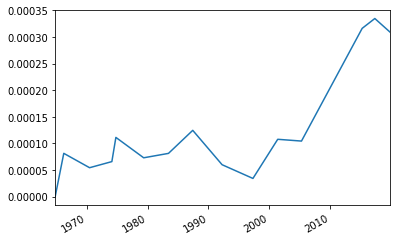

In [47]:
%matplotlib inline 
import pandas as pd # import pandas
pd.Series(results).plot() # convert Counter to a pandas.Series and apply the `.plot()` method

## Extensions

We create a few more examples that extend the functionalities of our word-counting program.

### Multiple words over time

Instead of plotting the evolution of just one word, we track the evolution of a group of words over time. The main differences with the previous program are:
- `target_terms` refers to a list and not a string (line 1)
- the code cell now contains a double `for` loop: we iterate over all files (line 4) and within this block (i.e. for each file) we iterate over each item in `target_terms` (we collect the counts for each query term). Please note the use of indentation (the second for loop is followed by extra white space). Again, this is not just to make the code more readable, it is part of the Python syntax.

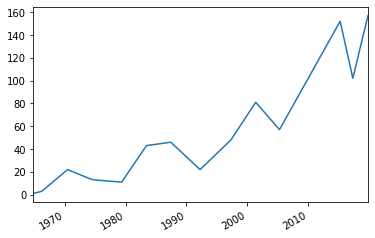

In [49]:
target_terms = ['poverty','poor'] # define query terms as a list
results = Counter() # create Counter to keep track of word counts

for fp in file_paths: # iterate over paths
    ts = path2timestamp(fp) # get time stamp from path
    word_counts = count_words(fp) # get word counts for document
    for target_term in target_terms: # iterate over the query terms
        count_for_target = word_counts[target_term] # get word count for a query
        results[ts]+= count_for_target # increment count for the specific time stamp

pd.Series(results).plot() # plot results

### Relative frequencies

The upward trend in the previous could be misleading: is poverty really becoming a more important issue? Or are the manifestos just getting longer and thus containing more words? To control for the size of the corpus, we can compute the **relative** frequency of terms: we count how often a word appears and divide this by the total number of tokens).

In the example below, we slightly change the function for counting words. Instead of only returning dictionary (or Counter) with word type frequencies, it also returns the total number of tokens. We name this extended function `count_words2` not to overwrite the function we created earlier.

In [37]:
def count_words2(path):
    text = open(path,'r').read() # open and read the document 
    text_lowercase = text.lower() # lowercase the text file
    tokens = word_tokenize(text_lowercase) # get tokens
    word_counts = Counter(tokens) # count tokens
    return word_counts,len(tokens) # return word frequencies and the total number of tokens

We also add one more `Counter()` to keep track of the total number of tokens for each year

In [56]:
target_terms = ['austerity','cuts'] # formulate queries
word_counts = Counter() # create dictionary for storing the frequency of our query for earch time stamp
total_counts = Counter() #  create dictionary for storing total word counts for earch time stamp


for fp in file_paths: # iterate over paths
    year = path2timestamp(fp) # get timestamp from path
    word_count,total_count = count_words2(fp) # get the word counts and the total number of tokens
    for target_term in target_terms: # 
        count_for_target = word_count[target_term]
        word_counts[year]+= count_for_target
        total_counts[year]+= total_count


Before we plot the results, we need to divide the frequency of our query by the total number of words. Please have conulst the Breakout on dictionaries for my information about the how to work with this data type.

In [62]:
results = {}  # empty dictionary where we save relative frequency
for year in word_counts.keys(): # iterate over all time stamps in the word counts dictionary
    results[year] = word_counts[year] / total_counts[year] # divide the frequency of query by the total number of word for 

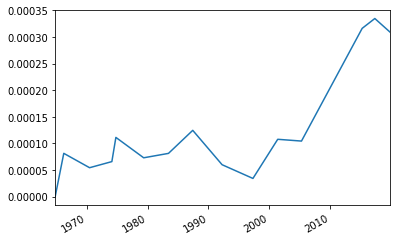

In [63]:
pd.Series(results).plot()

## Fin.